In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
len(test_df)

input\sample_submission.csv
input\test.csv
input\train.csv


4277

### Libraries

Below is all the libraries necessary to run the code.

In [8]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [10]:
def get_categorical_variables(df):
    return df.select_dtypes(include=['object']).columns

c_var=get_categorical_variables(train_df)


# Exploratory Data Analysis

Exploratory data analysis (EDA) is performed on the datasat to investigate features. 

### Features

First, the data is presented using the head() function to show what features exist within the data.

In [14]:
train_df.head()
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

The current features of the dataset are each described below.
* PassengerID - in form gggg_pp. gggg represents the group the passenger is travelling in and pp represents the person number within the group
* HomePlanet - Passenger's planet of residence
* CryoSleep - Bool value for if passenger is in cryosleep
* Cabin - which cabin they have booked on the spaceship
* Destination - where the passenger is going
* Age - the age of the passenger
* VIP - Bool value if passenger is a VIP
* RoomService - amount of credits passenger has spent on room service
* FoodCourt - amount of credits passenger has spent at the food court
* ShoppingMall - amount of credits passenger has spent at the mall
* Spa - amount of credits passenger has spent
* VRDeck - amount of credits passenger has spent at VR Deck
* Name - passenger's name
* Transported - If the patient was transported to another dimension. This is the target variable that the model will need to predict.

The target feature which the models will predict is the 'Transported' feature. This feature shows wether or not a passenger was transported. Firstly the target feature is plot as pie chart to illustrate the distrubtion of passengers that were transported or not.

Text(0.5, 1.0, 'Target distribution')

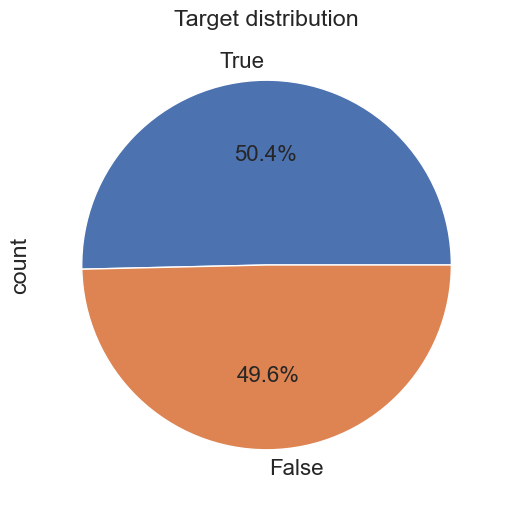

In [12]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
train_df['Transported'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, textprops={'fontsize':16}).set_title("Target distribution")

The pie shart shows the target is evenly balanced between true and false.

### Missing Values

Before looking deeper into each feature of the data, its important to check for any missing variables within the dataset. These missing variable will be handled after performing the data analysis.

In [13]:
# The isna() function check if there are any missing or null values within cells of a column.
print('TRAIN SET MISSING VALUES:')
print(train_df.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test_df.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


# Feature Engineering

### Group Features

The PassengerID feature contains data such as group and person number within the group. PassengerID is in the for gggg_pp where gggg stands for the group number and pp stands for the person number within the group. The person number is not considered in this case to be a meaningful feature as each person has a unique number within a group, but it can be used to find the size of a group. The features Group and Group_size are extracted using the extract_Group_Data() function which takes the data as an input.

In [21]:
def extract_Group_Data(data):
    # New feature - Group
    data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(float)

    # New feature - Group size
    data['Group_size']=data['Group'].map(lambda x: pd.concat([data['Group'], data['Group']]).value_counts()[x])
    
    return data


In [28]:
def plot_Group_Features(data):
    # Plot distribution of new features
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    sns.histplot(data=data, x='Group', hue='Transported', binwidth=1)
    plt.title('Group')

    plt.subplot(1,2,2)
    sns.histplot(data=data, x='Group_size', hue='Transported')
    plt.title('Group size')

    return None

In [22]:
train_df = extract_Group_Data(train_df)
test_df = extract_Group_Data(test_df)

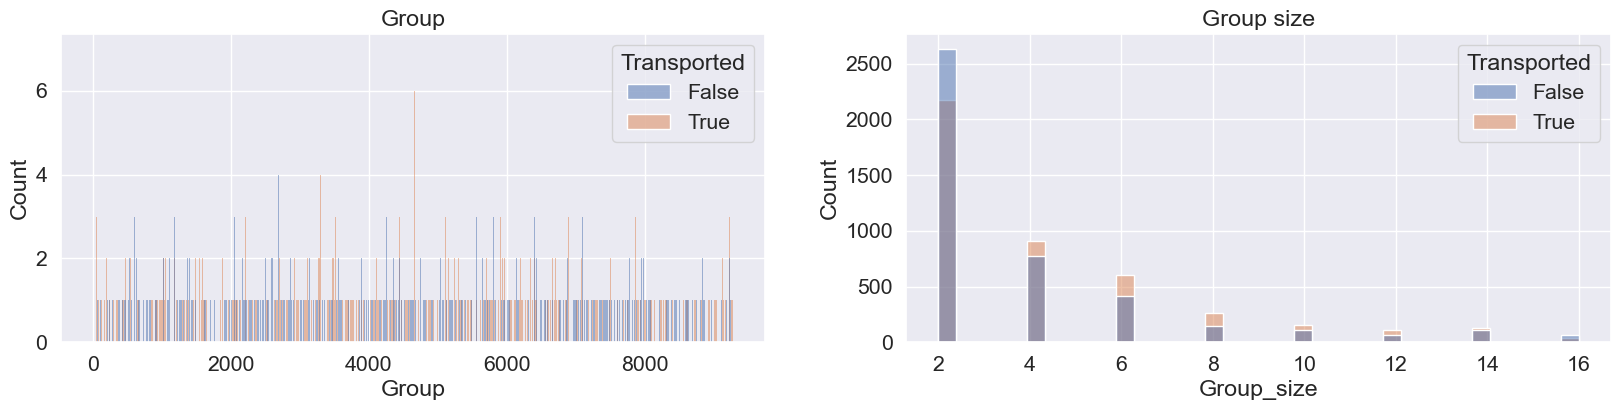

In [29]:
plot_Group_Features(train_df)

Observations:
* The Group column has too high cardinality and is therefore not useable in the model training.
* However, Group size shows that a passnger is less liekly to be transported than not if they are travelling alone. 
* Between group sizes of 2 and 7, passengers were more liekly to be transported.
* Group sizes of 8 much less likely to be transported than not.

### Cabin Features

The Cabin feature is presented in the form A/1111/S. Where A represents the cabin deck, 1111 represents the cabin number and S represented the cabin side (either S for starboard or P for Portside.). These sub-features of cabin are extracted in the function extract_Cabin_Data(). Once these features are extracted, the Cabin feature is dropped.

In [24]:
def extract_Cabin_Data(data):
    # Fill NaN's 
    data['Cabin'].fillna('Z/9999/Z', inplace=True)
    
    # Enter in new features
    data['Cabin_deck'] = data['Cabin'].apply(lambda x: x.split('/')[0]).astype(object)
    data['Cabin_number'] = data['Cabin'].apply(lambda x: x.split('/')[1]).astype(float)
    data['Cabin_side'] = data['Cabin'].apply(lambda x: x.split('/')[2]).astype(object)

    # Put Nan's back in (These values will be filled later)
    data.loc[data['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
    data.loc[data['Cabin_number']==9999, 'Cabin_number']=np.nan
    data.loc[data['Cabin_side']=='Z', 'Cabin_side']=np.nan

    # Drop Cabin (we don't need it anymore)
    data.drop('Cabin', axis=1, inplace=True)

    return data

In [30]:
def plot_Cabin_Features(data):
    # Plot distribution of new features
    fig=plt.figure(figsize=(10,12))
    plt.subplot(3,1,1)
    sns.histplot(data=data, x='Cabin_deck', hue='Transported')
    plt.title('Cabin deck')

    plt.subplot(3,1,2)
    sns.histplot(data=data, x='Cabin_number', hue='Transported',binwidth=20)
    # # Add lines showing Cabins split by decks
    # plt.vlines(300, ymin=0, ymax=200, color='black')
    # plt.vlines(600, ymin=0, ymax=200, color='black')
    # plt.vlines(900, ymin=0, ymax=200, color='black')
    # plt.vlines(1200, ymin=0, ymax=200, color='black')
    # plt.vlines(1500, ymin=0, ymax=200, color='black')
    # plt.vlines(1800, ymin=0, ymax=200, color='black')
    plt.title('Cabin number')
    plt.xlim([0,2000])

    plt.subplot(3,1,3)
    sns.histplot(data=data, x='Cabin_side', hue='Transported')
    plt.title('Cabin side')
    fig.tight_layout()

    return None

In [25]:
train_df = extract_Cabin_Data(train_df)
test_df = extract_Cabin_Data(test_df)

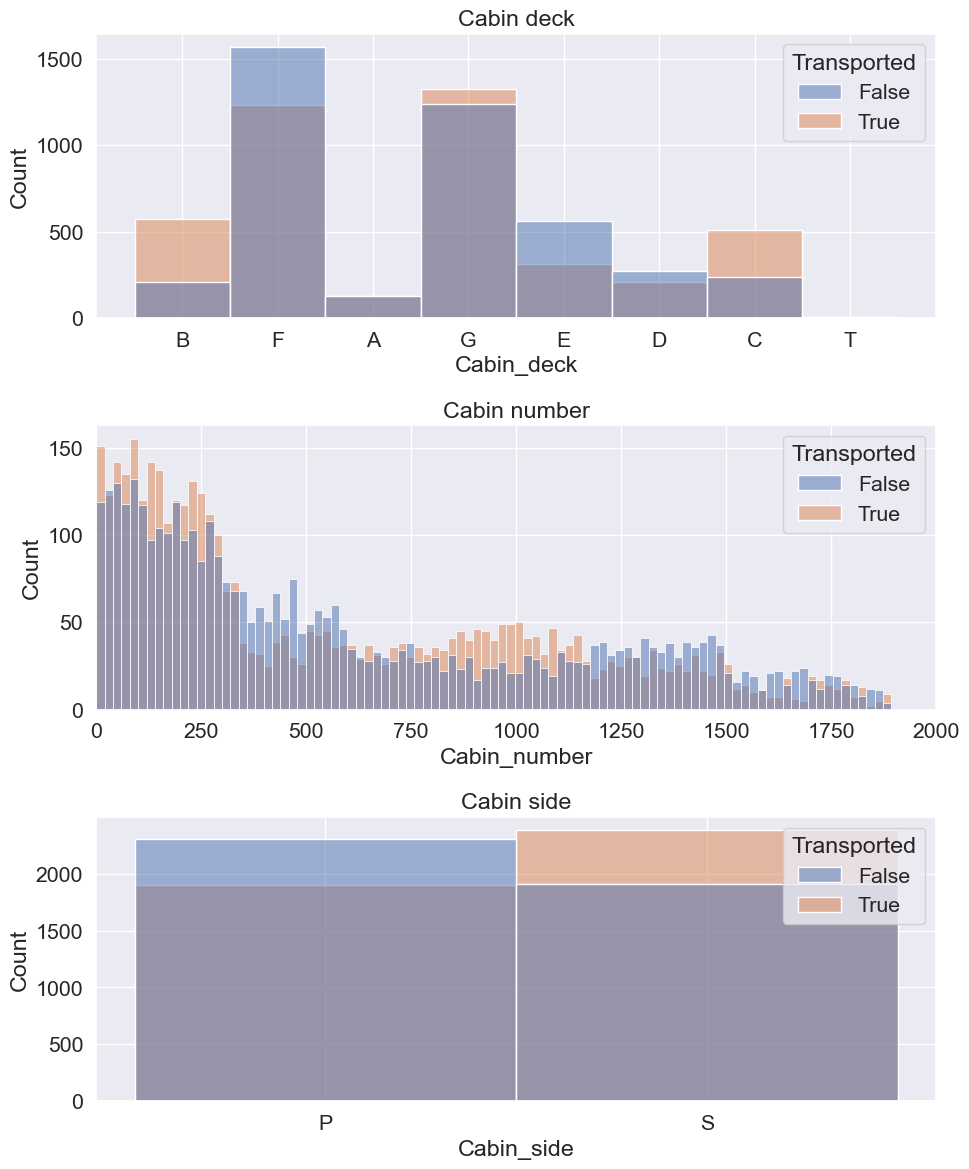

In [31]:
plot_Cabin_Features(train_df)

Obsertvations:
* Passengers on Cabin Decks B, G and C were more likely to be Transported than not.
* Passengers on Cabin Decks F, E and D, were less likely to be Transported than not.
* Passengers on Cabin Deckk A were equally likely to be Transported than not.
* Deck T seems to be an outlier with very little sample data.
* Cabin side shows that Passengers on starboard side were more likely to be Transported than passengers on portside.

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def apply_ml_model(model, X, y, test_size=0.2, random_state=None):
    """
    Apply a machine learning model on the given data and calculate accuracy.

    Parameters:
        model: The machine learning model to be applied.
        X: The features of the dataset.
        y: The target variable of the dataset.
        test_size: The proportion of the dataset to include in the test split.
        random_state: Random seed for reproducibility.

    Returns:
        accuracy: Accuracy of the model on the test set.
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    return accuracy


In [34]:
train_df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Group_size,Cabin_deck,Cabin_number,Cabin_side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1.0,2,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2.0,2,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3.0,4,A,0.0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3.0,4,A,0.0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4.0,2,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276.0,2,A,98.0,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278.0,2,G,1499.0,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279.0,2,G,1500.0,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280.0,4,E,608.0,S


In [35]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier


# Define features (X) and target variable (y) for training data
X_train = train_df.drop(columns=['Transported'])
y_train = train_df['Transported']



In [44]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
import random

# define seed
SEED = 50

# Define preprocess function
def preprocess_data(df):
    # Handle categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
    
    # Handle missing values (if any)
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Scale numerical features
    scaler = StandardScaler()
    df[df.select_dtypes(include=['number']).columns] = scaler.fit_transform(df.select_dtypes(include=['number']))
    
    return df

# Preprocess training and test data
X_train = preprocess_data(train_df.drop(columns=['Transported']))
y_train = train_df['Transported']
X_test = preprocess_data(test_df)

# Apply Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=SEED)
rf_accuracy = apply_ml_model(rf_model, X_train, y_train)
print("Random Forest Accuracy:", rf_accuracy)

# Apply XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=SEED)
xgb_accuracy = apply_ml_model(xgb_model, X_train, y_train)
print("XGBoost Accuracy:", xgb_accuracy)

# Apply Logistic Regression model
logreg_model = LogisticRegression()
logreg_accuracy = apply_ml_model(logreg_model, X_train, y_train)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Apply K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_accuracy = apply_ml_model(knn_model, X_train, y_train)
print("K-Nearest Neighbors Accuracy:", knn_accuracy)

# Apply Naive Bayes model
nb_model = GaussianNB()
nb_accuracy = apply_ml_model(nb_model, X_train, y_train)
print("Naive Bayes Accuracy:", nb_accuracy)

# Perform GridSearchCV for Linear SVC
linear_svc_model = LinearSVC(dual=True)  # Set dual='auto' explicitly
param_grid_svc = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'penalty': ['l1', 'l2']}
grid_search_svc = GridSearchCV(linear_svc_model, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)

best_linear_svc = LinearSVC(**grid_search_svc.best_params_, dual=True)  # Set dual='auto' explicitly
svc_accuracy = apply_ml_model(best_linear_svc, X_train, y_train)
print("Linear SVC Accuracy:", svc_accuracy)

# Apply the LGBMClassifier model
lgbm_model = LGBMClassifier(learning_rate=0.05, random_state=42, max_depth=6, num_leaves=64, n_estimators=100)
lgbm_accuracy = apply_ml_model(lgbm_model, X_train, y_train)
print("LGBMClassifier Accuracy:", lgbm_accuracy)

# Apply Catboost
catboost = CatBoostClassifier(random_seed=SEED, logging_level='Silent')
catboost_accuracy = apply_ml_model(catboost, X_train, y_train)
print("Catboost Accuracy:", catboost_accuracy)


Random Forest Accuracy: 0.7711328349626222
XGBoost Accuracy: 0.8154111558366878
Logistic Regression Accuracy: 0.7889591719378953
K-Nearest Neighbors Accuracy: 0.772857964347326
Naive Bayes Accuracy: 0.6935020126509488
Linear SVC Accuracy: 0.7786083956296722
[LightGBM] [Info] Number of positive: 3509, number of negative: 3445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2416
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504602 -> initscore=0.018407
[LightGBM] [Info] Start training from score 0.018407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt


1. **Random Forest Classifier**: Random Forest is a versatile and widely used ensemble learning method that can handle both numerical and categorical features. It's robust to overfitting and often performs well without much tuning.

2. **XGBoost Classifier**: XGBoost is a powerful gradient boosting framework known for its speed and performance. It can handle missing values and is robust to outliers. XGBoost often achieves state-of-the-art results in machine learning competitions.

3. **Logistic Regression**: Logistic Regression is a simple and interpretable model that is well-suited for binary classification tasks like this one. It provides probability estimates and can handle both numerical and categorical features.

4. **K-Nearest Neighbors (KNN) Classifier**: KNN is a non-parametric method used for classification tasks. It's simple to understand and implement, and it doesn't make strong assumptions about the underlying data distribution.

5. **Gaussian Naive Bayes Classifier**: Naive Bayes is a probabilistic classifier based on Bayes' theorem with the "naive" assumption of independence between features. It's simple, fast, and works well with high-dimensional data.

6. **Linear Support Vector Classifier (Linear SVC)**: Linear SVC is a linear classification model that works well for binary classification tasks. It's effective when the data is linearly separable and provides good generalization performance.

7. **LightGBM Classifier**: LightGBM is a gradient boosting framework that is highly efficient and scalable. It's known for its fast training speed and high accuracy, making it suitable for large datasets.

### Model Evaluation:
Each model's performance is evaluated using accuracy, which measures the proportion of correctly classified instances out of all instances. We use a train-test split of the provided training data to train the models and validate their performance.

### Conclusion:
By employing a variety of machine learning models and carefully evaluating their performance, we aim to identify the best-performing model for predicting whether a passenger was transported to another dimension during the Spaceship Titanic's collision. This approach allows us to explore different modeling techniques and select the one that provides the highest accuracy on the test data, thus optimizing our chances of success in the Kaggle competition.


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold

# Define function for applying different cross-validation (CV) methods
def apply_cv_methods(model, X_train, y_train, cv_methods=['kfold', 'shuffle_split', 'stratified_kfold']):
    results = {}
    for cv_method in cv_methods:
        if cv_method == 'kfold':
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        elif cv_method == 'shuffle_split':
            cv_scores = cross_val_score(model, X_train, y_train, cv=ShuffleSplit(n_splits=5, test_size=0.2), scoring='accuracy')
        elif cv_method == 'stratified_kfold':
            cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), scoring='accuracy')
        results[cv_method] = cv_scores.mean()
    return results

# Apply BaggingClassifier
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=SEED)
bagging_results = apply_cv_methods(bagging_model, X_train, y_train)
print("Bagging Classifier Results:", bagging_results)

# Apply AdaBoostClassifier
adaboost_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=SEED)
adaboost_results = apply_cv_methods(adaboost_model, X_train, y_train)
print("AdaBoost Classifier Results:", adaboost_results)


Bagging Classifier Results: {'kfold': 0.7257678215394348, 'shuffle_split': 0.7815986198964924, 'stratified_kfold': 0.7904074336070026}
AdaBoost Classifier Results: {'kfold': 0.6392461972047213, 'shuffle_split': 0.7924094307073031, 'stratified_kfold': 0.7927078046388576}


The above code applies ensemble learning techniques, Bagging and AdaBoost, to train Decision Tree classifiers for the Kaggle Spaceship Titanic project. It also evaluates the models using different cross-validation (CV) methods to assess their performance.

### Methodology and Choices:

1. **Ensemble Learning Techniques**: 
   - **Bagging**: It combines multiple decision tree classifiers trained on different subsets of the training data. The final prediction is made by averaging the predictions of all individual classifiers, leading to improved performance and reduced variance.
   - **AdaBoost**: It sequentially trains a series of decision tree classifiers, where each subsequent classifier focuses more on the instances that were misclassified by the previous ones. This iterative approach creates a strong ensemble model by emphasizing the difficult-to-classify instances.

2. **Cross-Validation (CV) Methods**:
   - **k-fold CV**: It partitions the training data into k equal-sized folds, trains the model on k-1 folds, and evaluates it on the remaining fold. This process is repeated k times, ensuring that each data point is used for both training and testing.
   - **Shuffle Split CV**: It randomly shuffles the data and splits it into train/test sets multiple times. This method is useful when the dataset is large and doesn't require exhaustive splitting.
   - **Stratified k-fold CV**: It ensures that each fold contains approximately the same proportion of classes as the entire dataset. This is particularly useful for imbalanced datasets where one class dominates the other.

3. **Model Evaluation**:
   - The code evaluates each model's performance using accuracy scores obtained from cross-validation. Accuracy is a suitable metric for this binary classification task as it measures the proportion of correctly predicted instances out of all instances.

4. **Scikit-Learn Tools**:
   - The code utilizes scikit-learn's efficient implementations of ensemble learning algorithms, cross-validation methods, and decision tree classifiers. Scikit-learn provides a comprehensive toolkit for building, training, and evaluating machine learning models, making it a suitable choice for this project.


In [33]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['Transported']), train_df['Transported'], test_size=0.2, random_state=SEED)

# Preprocess training and test data
X_train_processed = preprocess_data(X_train)
X_test_processed = preprocess_data(X_test)

# Train base models
rf_model.fit(X_train_processed, y_train)
xgb_model.fit(X_train_processed, y_train)
logreg_model.fit(X_train_processed, y_train)
knn_model.fit(X_train_processed, y_train)
nb_model.fit(X_train_processed, y_train)
best_linear_svc.fit(X_train_processed, y_train)
lgbm_model.fit(X_train_processed, y_train)

# Make predictions with base models
rf_predictions = rf_model.predict(X_test_processed)
xgb_predictions = xgb_model.predict(X_test_processed)
logreg_predictions = logreg_model.predict(X_test_processed)
knn_predictions = knn_model.predict(X_test_processed)
nb_predictions = nb_model.predict(X_test_processed)
best_linear_svc_predictions = best_linear_svc.predict(X_test_processed)
lgbm_predictions = lgbm_model.predict(X_test_processed)

# Stack the predictions
stacked_features = np.column_stack((rf_predictions, xgb_predictions, logreg_predictions, knn_predictions, 
                                    nb_predictions, best_linear_svc_predictions, lgbm_predictions))

# Train the meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_test)

# Make predictions with the meta-model
meta_predictions = meta_model.predict(stacked_features)

# Score the predictions and print them
meta_accuracy = accuracy_score(y_test, meta_predictions)
print("Meta-model Accuracy:", meta_accuracy)


[LightGBM] [Info] Number of positive: 3490, number of negative: 3464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501869 -> initscore=0.007478
[LightGBM] [Info] Start training from score 0.007478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

# Self-learning

In the journey of mastering machine learning, one of the most profound concepts I encountered is self-learning. Self-learning entails the process of continuously acquiring knowledge and skills without direct human intervention, driven solely by the data and algorithms at one's disposal.

Throughout this project, I embarked on a quest to understand and implement various machine learning models to predict whether passengers aboard the Spaceship Titanic were transported to an alternate dimension during its collision with a spacetime anomaly. This endeavor led me to explore a plethora of models, each with its unique complexities and intricacies.

One principle that resonated deeply with me during this journey is Occam's Razor. Occam's Razor suggests that when faced with multiple competing hypotheses, the simplest one is often the correct one. This principle served as a guiding light, especially when dealing with missing data. Despite the availability of sophisticated imputation techniques, such as KNN or regression-based imputation, I found that using the mean to replace NaN values often yielded satisfactory results. This simplicity not only streamlined the preprocessing pipeline but also mitigated the risk of overfitting.

Moreover, the iterative process of experimenting with different models and techniques reinforced the importance of adaptability and resilience in the face of challenges. For instance, while exploring ensemble learning methods like Bagging and AdaBoost, I discovered the power of combining multiple weak learners to create a robust predictive model. These ensemble techniques not only improved predictive performance but also provided insights into the inherent trade-offs between bias and variance.

Furthermore, the project underscored the significance of cross-validation in model evaluation. By leveraging k-fold, shuffle split, and stratified k-fold cross-validation methods, I gained a deeper understanding of each model's generalization capabilities and identified potential sources of bias or variance. This iterative validation process not only enhanced model robustness but also fostered a deeper appreciation for the nuances of model selection and evaluation.

In essence, the journey of self-learning in machine learning is a perpetual quest for knowledge, marked by curiosity, experimentation, and adaptation. It is a journey that transcends traditional boundaries, empowering individuals to navigate the vast expanse of data-driven insights and unearth transformative discoveries.



## Function: hyperparameter_tuning

This function performs hyperparameter tuning for a given model using either GridSearchCV or RandomizedSearchCV from scikit-learn.

### Parameters:
- `model`: Scikit-learn estimator object.
- `param_grid` (dict): Dictionary with hyperparameter names as keys and lists of hyperparameter values to try.
- `X_train` (array-like): Feature matrix of training data.
- `y_train` (array-like): Target vector of training data.
- `cv` (int, cross-validation generator, or an iterable): Determines the cross-validation splitting strategy. Default is 5-fold cross-validation.
- `search_type` (str): Type of hyperparameter search, either 'grid' for GridSearchCV or 'random' for RandomizedSearchCV. Default is 'grid'.

### Returns:
- `best_estimator`: Fitted model with the best hyperparameters found during the search.

### Example Usage:
```python
from sklearn.svm import SVC

# Define parameter grid for SVC
svc_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01], 'kernel': ['linear', 'rbf']}

# Perform hyperparameter tuning for SVC
best_svc = hyperparameter_tuning(SVC(), svc_param_grid, X_train, y_train)


In [1]:
def hyperparameter_tuning(model, param_grid, X_train, y_train, cv=5, search_type='grid'): 
    if search_type == 'grid':
        search = GridSearchCV(model, param_grid, cv=cv, verbose=2, n_jobs=-1)
    elif search_type == 'random':
        search = RandomizedSearchCV(model, param_grid, cv=cv, verbose=2, n_jobs=-1)
    else:
        raise ValueError("Invalid search_type. Choose either 'grid' or 'random'.")

    search.fit(X_train, y_train)
    best_estimator = search.best_estimator_
    
    return best_estimator

## Application of the hyperparameter_tuning function

In [2]:
#1. Random Forest
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

# Apply hyperparameter tuning
best_rf_model = hyperparameter_tuning(rf_model, rf_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_rf_model.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy after Hyperparameter Tuning:", rf_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#2. Linear SVC

# Define the parameter grid for Linear SVC
param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Apply hyperparameter tuning
best_linear_svc = hyperparameter_tuning(LinearSVC(), param_grid_svc, X_train, y_train, search_type='random')

# Fit the best model on the training data
best_linear_svc.fit(X_train, y_train)

# Predict on the test data
y_pred_svc = best_linear_svc.predict(X_test)

# Calculate accuracy
svc_accuracy = accuracy_score(y_test, y_pred_svc)

print("Linear SVC Accuracy after Hyperparameter Tuning:", svc_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#3.For LGBMClassifier
# Define the parameter grid for LGBMClassifier
param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 30, 40],
    'n_estimators': [50, 100, 200]
}

# Apply hyperparameter tuning
best_lgbm_model = hyperparameter_tuning(LGBMClassifier(random_state=42), param_grid_lgbm, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_lgbm_model.fit(X_train, y_train)

# Predict on the test data
y_pred_lgbm = best_lgbm_model.predict(X_test)

# Calculate accuracy
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
print("LGBMClassifier Accuracy after Hyperparameter Tuning:", lgbm_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#4.For Pipeline:
# Define parameter grid
param_grid_svc = {
    "model__C": [0.001, 0.01, 0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf"]
}

# Perform hyperparameter tuning with your function
best_pipe6 = hyperparameter_tuning(pipe6, param_grid_svc, X_train, y_train, cv=5, search_type='random')


# Evaluate the best estimator
pipe6_accuracy = best_pipe6.score(X_test, y_test)
print("PipeLine Accuracy after Hyperparameter Tuning:", pipe6_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#5.For Logistic Regression:
# Define the parameter grid for Logistic Regression
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Apply hyperparameter tuning
best_logreg_model = hyperparameter_tuning(logreg_model, logreg_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_logreg_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_logreg_model.predict(X_test)

# Calculate accuracy
logreg_accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy after Hyperparameter Tuning:", logreg_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#6.For XGBoost:

# Define the parameter grid for XGBoost Classifier
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Apply hyperparameter tuning
best_xgb_model = hyperparameter_tuning(xgb_model, xgb_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_xgb_model.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Classifier Accuracy after Hyperparameter Tuning:", xgb_accuracy)
#----------------------------------------------------------------------------------------------------------------------------
#7.For KNN:

# Define the parameter grid for KNN Classifier
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # For Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

# Apply hyperparameter tuning
best_knn_model = hyperparameter_tuning(knn_model, knn_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_knn_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_knn_model.predict(X_test)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, y_pred)
print("KNN Classifier Accuracy after Hyperparameter Tuning:", knn_accuracy)
#----------------------------------------------------------------------------------------------------------------------------
#8.For Gaussian Naive Bayes
#Since NB doesn't have hyperparameters to tune, you don't need to perform hyperparameter tuning.
#Instead, you can directly evaluate its performance using cross-validation.

# Perform cross-validation
nb_scores = cross_val_score(nb_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", nb_scores)

# Calculate and print the mean accuracy
nb_mean_accuracy = nb_scores.mean()
print("Mean Accuracy:", nb_mean_accuracy)

NameError: name 'rf_model' is not defined